<a href="https://colab.research.google.com/github/azizdafi/Cloud-Cover-Detection/blob/main/Cloud_Cover_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    - Cloud Cover Detection



##### **Project Type**    - DL-CNN

# **Project Summary -**

Write the summary here within 500-600 words.

# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


**Create a Vision Transformer (ViT) based model capable of accurately identifying and effectively masking clouds in multispectral satellite imagery, per pixel. These models should significantly elevate the quality of input data for Earth surface analysis, specifically benefiting analytical tasks reliant on accurate cloud removal and detection.**

Link to the dataset in multiple forms, as well as reference paper :
https://www.kaggle.com/datasets/hmendonca/cloud-cover-detection

# ***Let's Begin !***

## ***1. Know Your Data***

### Required installations

In [24]:
!pip install -q kaggle
!pip install rasterio
!pip install xarray-spatial

### Import Libraries

In [25]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import glob
import rasterio
from PIL import Image

#setting font size throughout the notebook
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18, 6))

from PIL import Image
import xarray as xr
from google.colab.patches import cv2_imshow
import xarray
import xrspatial.multispectral as ms
from pathlib import Path
import xarray



<Figure size 1800x600 with 0 Axes>

### Dataset Loading

In [3]:
# the below credentails are set to exire on 8th oct 2023, create your own credentails to execute the file.
# append the credentails content below within single quotes
json_credentials = '{"username":"azizdafi","key":"f9f762436373459b5feb81c467047ca5"}'

# create file kaggle.json and add the credentials to it.
cmd = """text_file = open("kaggle.json", "w+");text_file.write(json_credentials);text_file.close()"""
exec(cmd)
print("file created sucesfully")

# Load Dataset
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
print("json file moved to the destination folder")

# import the dataset from kaggel
!kaggle datasets download -d hmendonca/cloud-cover-detection
print("Data downloaded sucesfully \n extracting the data from downloaded zip file")

# unzip the downloaded file
!unzip cloud-cover-detection.zip
print("Unzip sucessfull, deleting  the zip file for memory optimization")

# remove the downloaded zip file to have optimize disc scpace
!rm -rf cloud-cover-detection.zip
print("zip file deleted sucessfully")

Streaming output truncated to the last 5000 lines.
  inflating: data/train_labels/phfl.tif  
  inflating: data/train_labels/phfr.tif  
  inflating: data/train_labels/phfv.tif  
  inflating: data/train_labels/phgh.tif  
  inflating: data/train_labels/phhg.tif  
  inflating: data/train_labels/phhx.tif  
  inflating: data/train_labels/phio.tif  
  inflating: data/train_labels/phje.tif  
  inflating: data/train_labels/phjk.tif  
  inflating: data/train_labels/phlf.tif  
  inflating: data/train_labels/phli.tif  
  inflating: data/train_labels/phlj.tif  
  inflating: data/train_labels/phmg.tif  
  inflating: data/train_labels/phmo.tif  
  inflating: data/train_labels/phnk.tif  
  inflating: data/train_labels/phog.tif  
  inflating: data/train_labels/phqs.tif  
  inflating: data/train_labels/phro.tif  
  inflating: data/train_labels/phss.tif  
  inflating: data/train_labels/phux.tif  
  inflating: data/train_labels/phwe.tif  
  inflating: data/train_labels/phwn.tif  
  inflating: data/train_l

### Dataset First View

In [26]:
# metadata First Look
# df = pd.read_csv("/content/train_metadata.csv")
df = pd.read_csv("/content/train_metadata.csv", parse_dates = ['datetime'])

df.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj


### Dataset Rows & Columns count

In [27]:
# Dataset Rows & Columns count
x = df.shape
print(f'the meta file has {x[0]} rows and {x[1]} columns')

the meta file has 11748 rows and 4 columns


### Dataset Information

In [28]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11748 entries, 0 to 11747
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   chip_id    11748 non-null  object             
 1   location   11748 non-null  object             
 2   datetime   11748 non-null  datetime64[ns, UTC]
 3   cloudpath  11748 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 367.2+ KB


#### Duplicate Values

In [29]:
# Dataset Duplicate Value Count
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 0


#### Missing Values/Null Values

In [30]:
# Missing Values/Null Values Count
missing_values = df.isna().sum()
print(missing_values)

chip_id      0
location     0
datetime     0
cloudpath    0
dtype: int64


### What did you know about your dataset?

Answer Here

## ***2. Understanding Your Variables***

In [31]:
# Dataset Columns
print(df.columns)

Index(['chip_id', 'location', 'datetime', 'cloudpath'], dtype='object')


In [32]:
# Dataset Describe
df.describe(include='all')

<ipython-input-32-1fb2dbb7a3f1>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,chip_id,location,datetime,cloudpath
count,11748,11748,11748,11748
unique,11748,81,91,11748
top,adwp,Chifunfu,2020-09-06 15:02:37+00:00,az://./train_features/adwp
freq,1,341,261,1
first,NaN,NaN,2018-03-07 08:46:02+00:00,NaN
last,NaN,NaN,2020-09-14 08:28:49+00:00,NaN


### Check Unique Values for each variable.

In [33]:
# Check Unique Values for each variable and listing values whose count is less than 25
for column in df.columns:
  res = len(df[column].unique())
  print(f"The number of unique variables in {column} column are: {res}")

The number of unique variables in chip_id column are: 11748
The number of unique variables in location column are: 81
The number of unique variables in datetime column are: 91
The number of unique variables in cloudpath column are: 11748


## 3. ***Data Wrangling***

### Data Wrangling Code

In [34]:
# generating features from the meta data
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['hour'] = df['datetime'].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

In [35]:
# creating paths to the different bands of images
BANDS = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
  "this function generates paths to the bands of file and adds to the dataframe"
  for band in bands:
    paths = []
    for x in df["chip_id"]:
      paths.append(f"{feature_dir}/{x}/{band}.tif")
    df[f"{band}_path"] = paths

    if label_dir is not None:
      label_paths = []
      for x in df["chip_id"]:
        label_paths.append(f"{label_dir}/{x}.tif")
      df["label_path"] = label_paths

  return df

df = add_paths(df, "/content/data/train_features", "/content/data/train_labels", BANDS)
df.head()


,chip_id,location,datetime,cloudpath,date,time,hour,year,month,B02_path,label_path,B03_path,B04_path,B08_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwp/B02.tif,/content/data/train_labels/adwp.tif,/content/data/train_features/adwp/B03.tif,/content/data/train_features/adwp/B04.tif,/content/data/train_features/adwp/B08.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwu/B02.tif,/content/data/train_labels/adwu.tif,/content/data/train_features/adwu/B03.tif,/content/data/train_features/adwu/B04.tif,/content/data/train_features/adwu/B08.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwz/B02.tif,/content/data/train_labels/adwz.tif,/content/data/train_features/adwz/B03.tif,/content/data/train_features/adwz/B04.tif,/content/data/train_features/adwz/B08.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adxp/B02.tif,/content/data/train_labels/adxp.tif,/content/data/train_features/adxp/B03.tif,/content/data/train_features/adxp/B04.tif,/content/data/train_features/adxp/B08.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/aeaj/B02.tif,/content/data/train_labels/aeaj.tif,/content/data/train_features/aeaj/B03.tif,/content/data/train_features/aeaj/B04.tif,/content/data/train_features/aeaj/B08.tif


In [36]:
# creating copy of the df as a backup
df_orignal = df.copy()

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

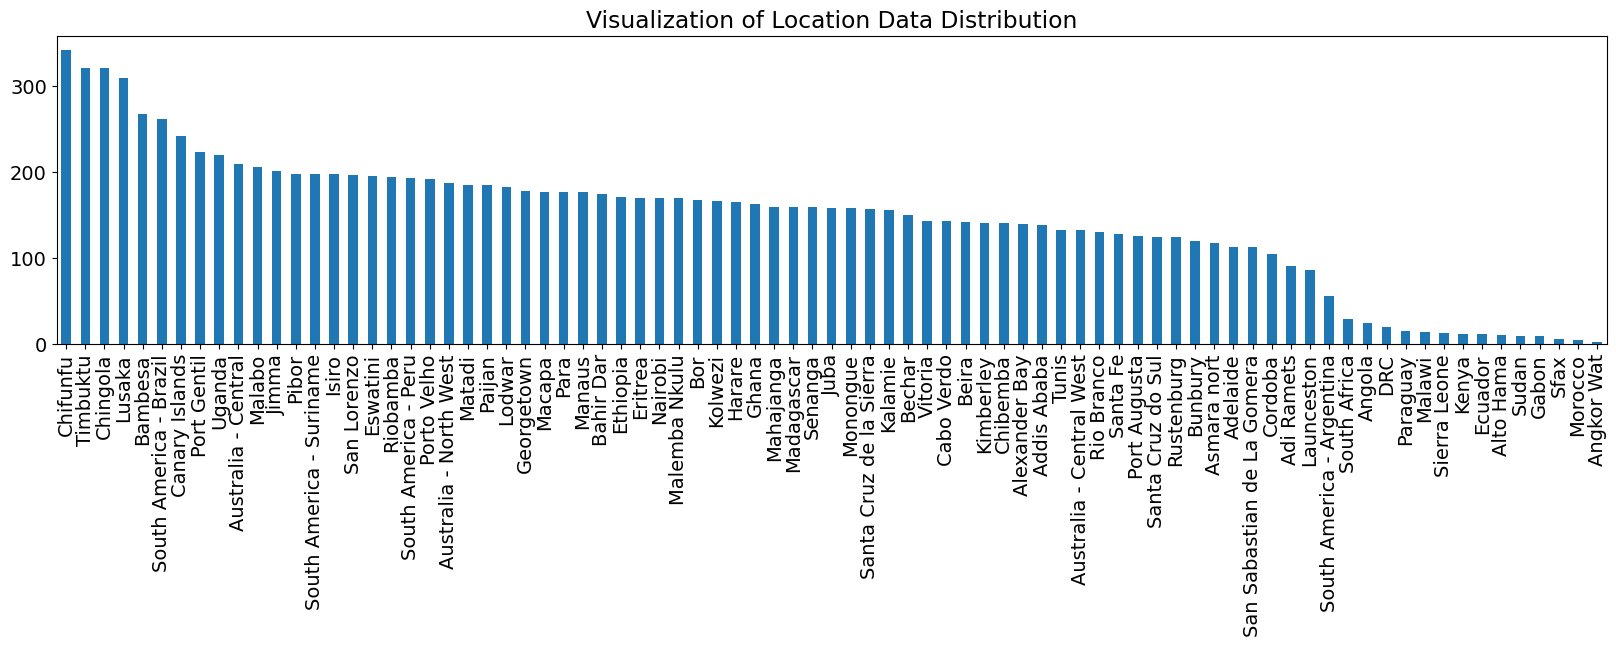

In [37]:
# Chart - 1  "Visualization of Location Data Distribution"

plt.figure(figsize=(20, 4))
df['location'].value_counts().plot.bar()
plt.title('Visualization of Location Data Distribution')
plt.show()

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 2

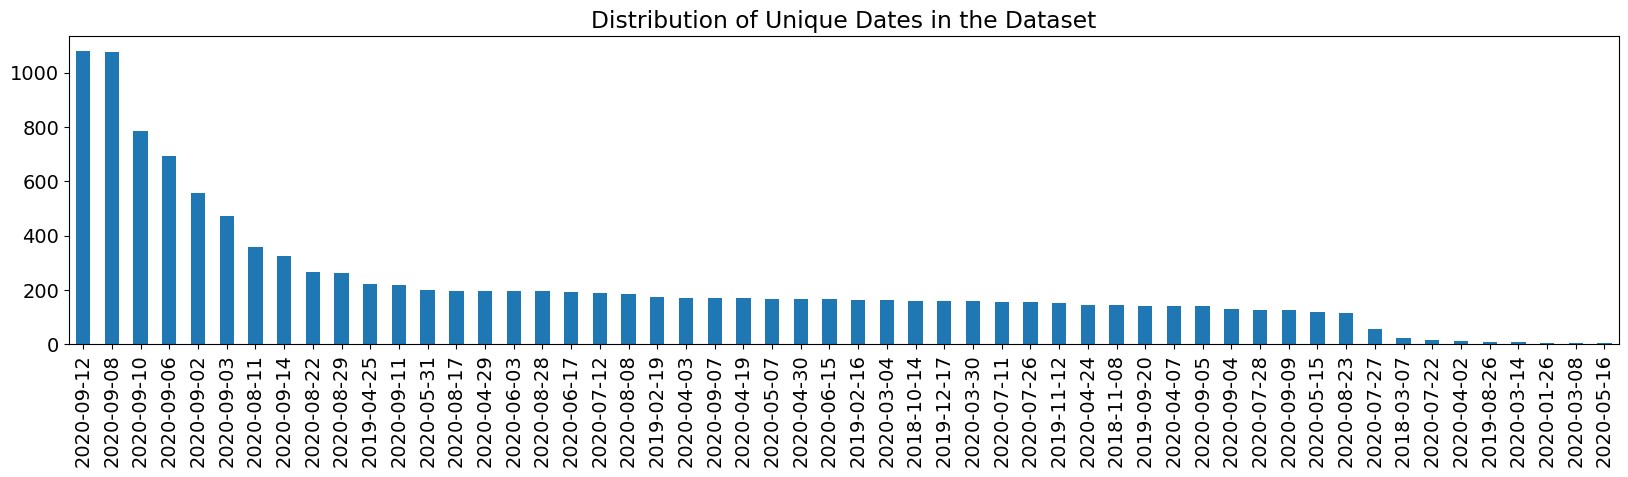

In [38]:
# Chart - 2 Distribution of Unique Dates in the Dataset
plt.figure(figsize=(20, 4))
df['date'].value_counts().plot.bar()
plt.title(f'Distribution of Unique Dates in the Dataset')
plt.show()

In [39]:
print("top 5 most captured data")
df['date'].value_counts().head(5)

top 5 most captured data


2020-09-12    1080
2020-09-08    1074
2020-09-10     783
2020-09-06     693
2020-09-02     555
Name: date, dtype: int64

In [21]:
df

,chip_id,location,datetime,cloudpath,date,time,hour,year,month,B02_path,label_path,B03_path,B04_path,B08_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwp/B02.tif,/content/data/train_labels/adwp.tif,/content/data/train_features/adwp/B03.tif,/content/data/train_features/adwp/B04.tif,/content/data/train_features/adwp/B08.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwu/B02.tif,/content/data/train_labels/adwu.tif,/content/data/train_features/adwu/B03.tif,/content/data/train_features/adwu/B04.tif,/content/data/train_features/adwu/B08.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adwz/B02.tif,/content/data/train_labels/adwz.tif,/content/data/train_features/adwz/B03.tif,/content/data/train_features/adwz/B04.tif,/content/data/train_features/adwz/B08.tif
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/adxp/B02.tif,/content/data/train_labels/adxp.tif,/content/data/train_features/adxp/B03.tif,/content/data/train_features/adxp/B04.tif,/content/data/train_features/adxp/B08.tif
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020-04-29,08:20:47,8,2020,4,/content/data/train_features/aeaj/B02.tif,/content/data/train_labels/aeaj.tif,/content/data/train_features/aeaj/B03.tif,/content/data/train_features/aeaj/B04.tif,/content/data/train_features/aeaj/B08.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11743,zxwv,Launceston,2020-09-06 00:08:20+00:00,az://./train_features/zxwv,2020-09-06,00:08:20,0,2020,9,/content/data/train_features/zxwv/B02.tif,/content/data/train_labels/zxwv.tif,/content/data/train_features/zxwv/B03.tif,/content/data/train_features/zxwv/B04.tif,/content/data/train_features/zxwv/B08.tif
11744,zxxo,Launceston,2020-09-06 00:08:20+00:00,az://./train_features/zxxo,2020-09-06,00:08:20,0,2020,9,/content/data/train_features/zxxo/B02.tif,/content/data/train_labels/zxxo.tif,/content/data/train_features/zxxo/B03.tif,/content/data/train_features/zxxo/B04.tif,/content/data/train_features/zxxo/B08.tif
11745,zxym,Launceston,2020-09-06 00:08:20+00:00,az://./train_features/zxym,2020-09-06,00:08:20,0,2020,9,/content/data/train_features/zxym/B02.tif,/content/data/train_labels/zxym.tif,/content/data/train_features/zxym/B03.tif,/content/data/train_features/zxym/B04.tif,/content/data/train_features/zxym/B08.tif
11746,zxza,Launceston,2020-09-06 00:08:20+00:00,az://./train_features/zxza,2020-09-06,00:08:20,0,2020,9,/content/data/train_features/zxza/B02.tif,/content/data/train_labels/zxza.tif,/content/data/train_features/zxza/B03.tif,/content/data/train_features/zxza/B04.tif,/content/data/train_features/zxza/B08.tif


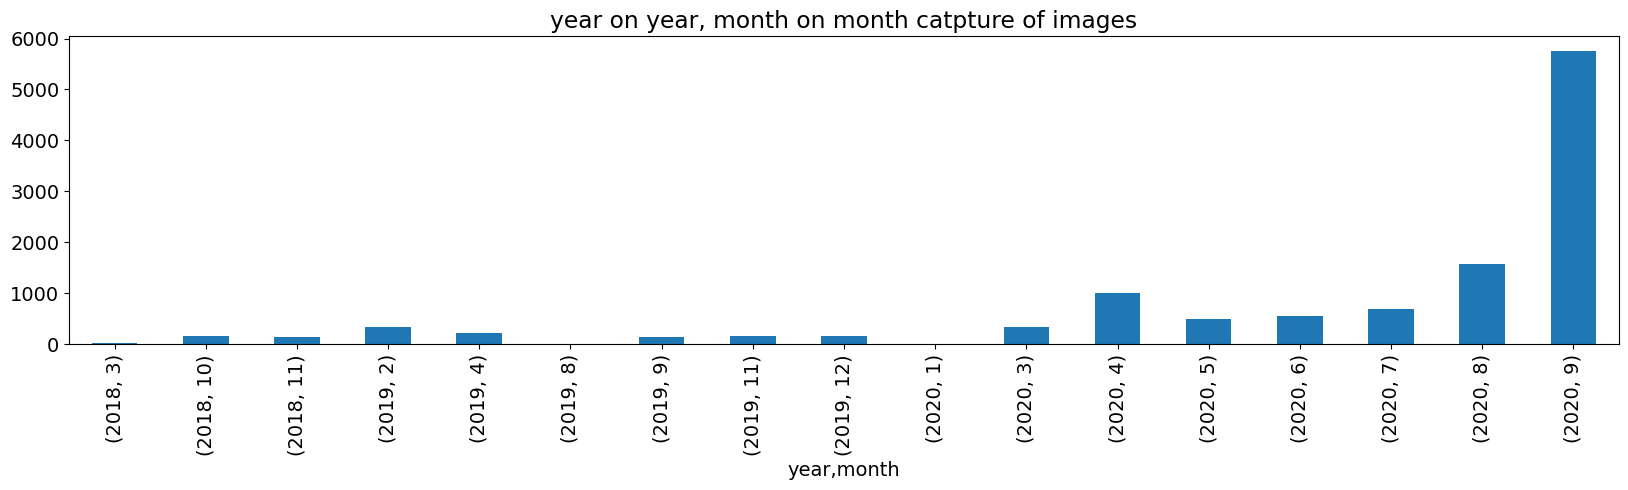

In [42]:
plt.figure(figsize=(20, 4))
df.groupby(['year', 'month']).month.count().plot(kind='bar', stacked=True)
plt.title(f'year on year and month on month catpture of images')
plt.show()

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 3

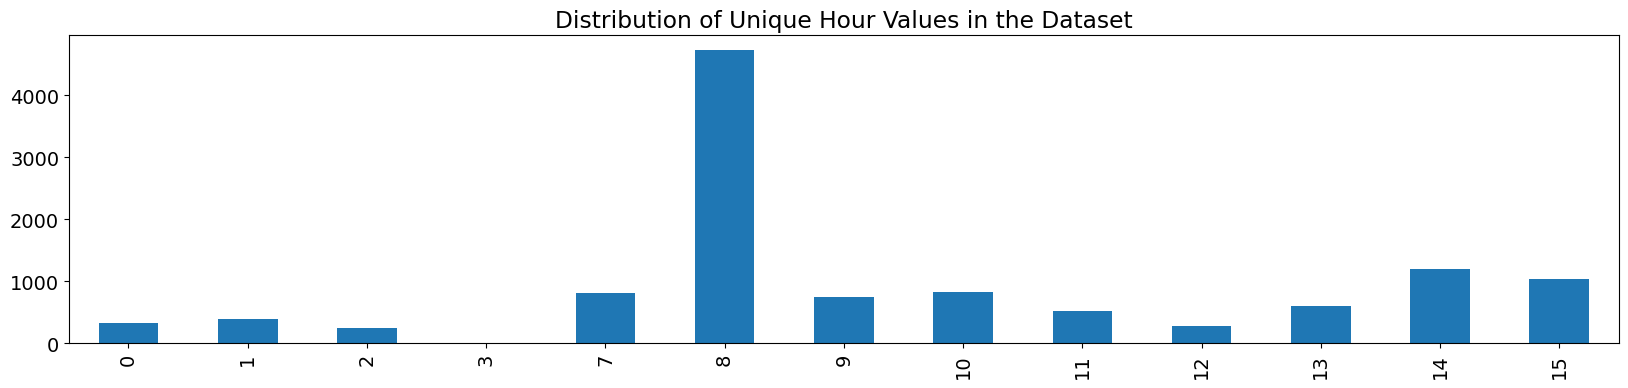

In [47]:
# Chart - 3 Distribution of Unique Hour Values in the Dataset
plt.rcParams['figure.figsize'] = (20,4)
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Distribution of Unique Hour Values in the Dataset')
plt.show()

In [48]:
print("Top 5 hours where most of the images were Taken")
df['hour'].value_counts().head(5)

Top 5 hours where most of the images were Taken


8     4733
14    1202
15    1039
10     827
7      810
Name: hour, dtype: int64

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 4

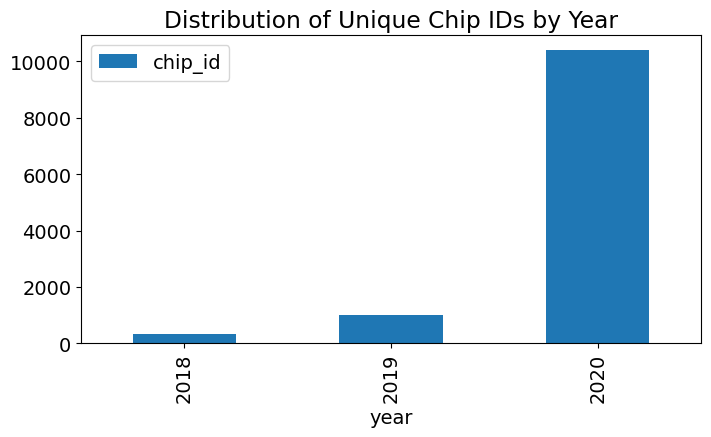

In [49]:
# Chart - 4 Distribution of Unique Chip IDs by Year
plt.rcParams['figure.figsize'] = (8,4)
df.groupby("year")[["chip_id"]].nunique().sort_index().plot.bar()
plt.title('Distribution of Unique Chip IDs by Year')
plt.show()


##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 5

chip_id       0
location      0
datetime      0
cloudpath     0
date          0
time          0
hour          0
year          0
month         0
B02_path      0
label_path    0
B03_path      0
B04_path      0
B08_path      0
dtype: int64


<Axes: >

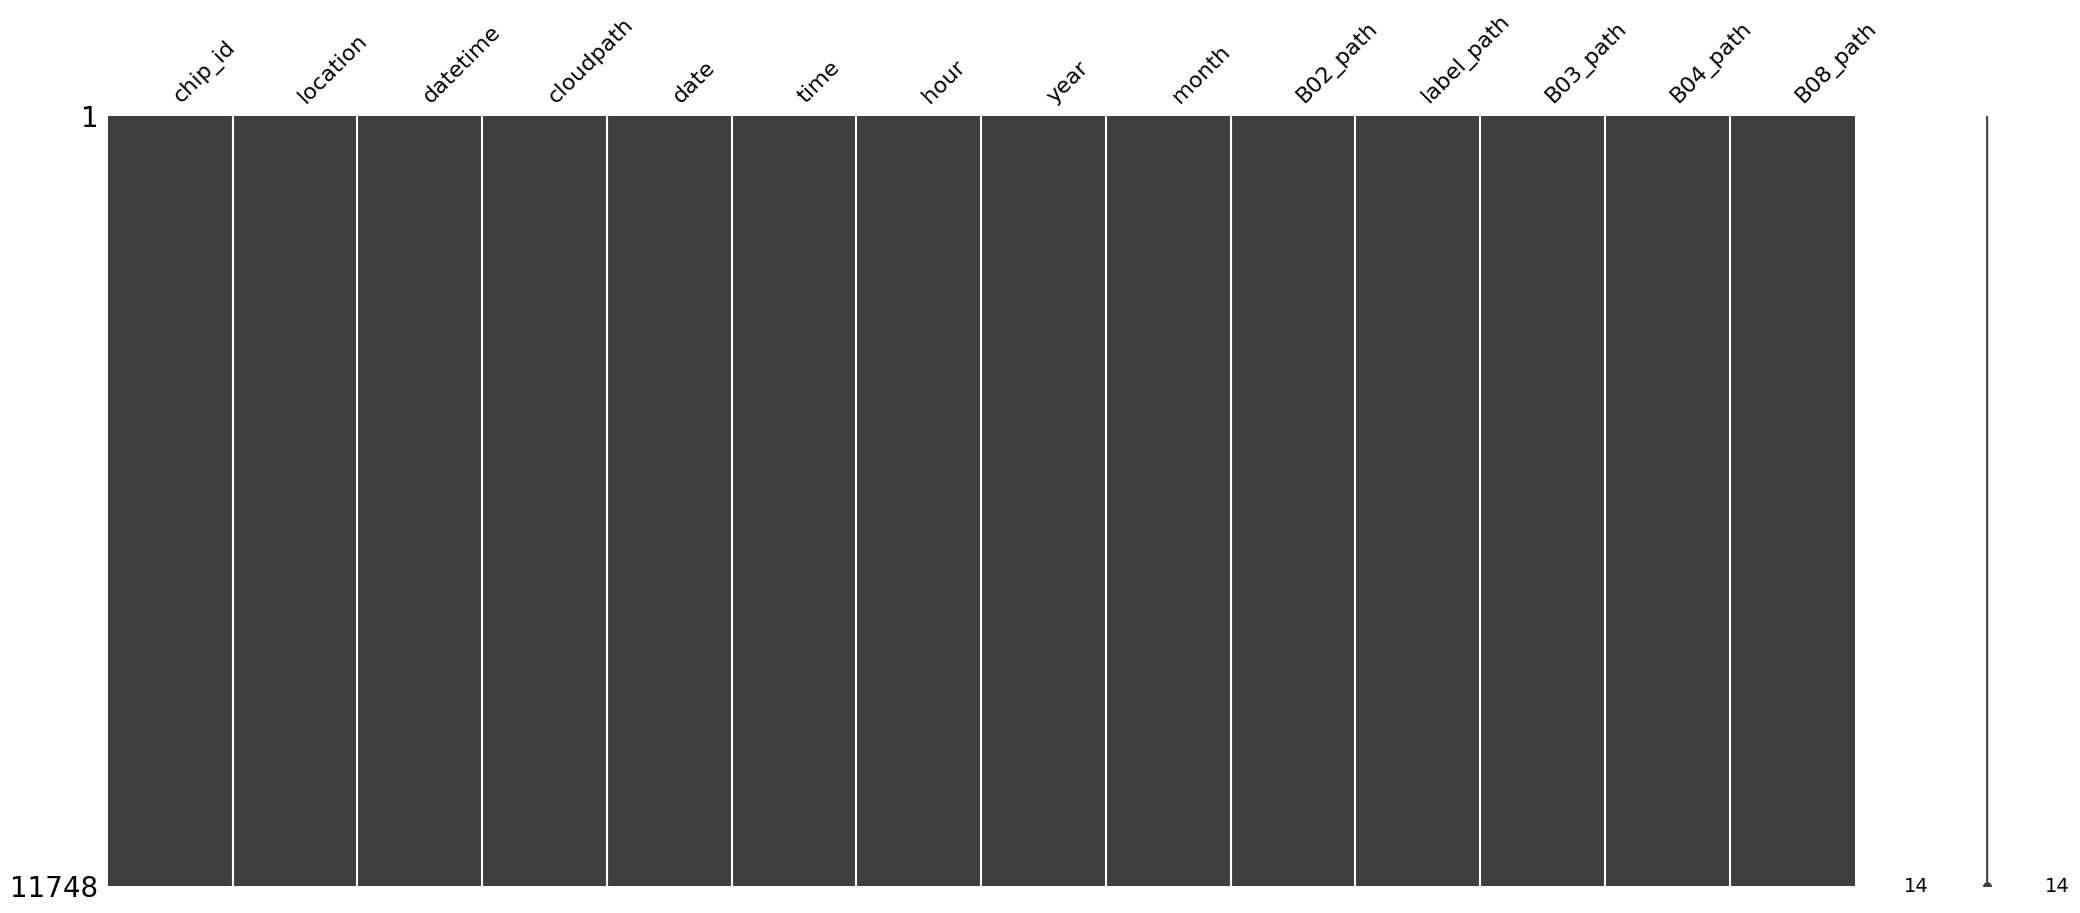

In [50]:
# Chart - 5 visualization code
print(df.isna().sum())
msno.matrix(df)

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 6

In [51]:
# Chart - 6 visualization code
print(f'Number of train features are {len(glob.glob("data/train_features/*"))}')
#
print(f'number of files prestent in each train features folders = {len(glob.glob("data/train_features/*/*"))}')

Number of train features are 11748
number of files prestent in each train features folders = 46992


##### 2. What is/are the insight(s) found from the chart?

In [52]:
len(glob.glob("data/train_features/*"))*len(BANDS) == len(glob.glob("data/train_features/*/*"))

True

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 7

In [53]:
example_chip = df.sample(1)
example_chip = example_chip.iloc[0]

In [54]:
# Chart - 7 visualization code

with rasterio.open(example_chip["B08_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32735),
 'transform': Affine(10.0, 0.0, 631805.0,
        0.0, -10.0, 8227310.0)}

In [55]:
print("Image array shape:", img_array.shape)

Image array shape: (512, 512)


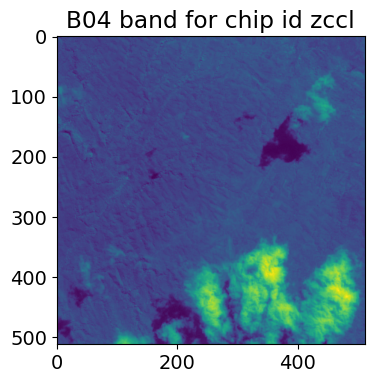

In [56]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

In [57]:
with rasterio.open(example_chip["B02_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 28.25609497513944, latitude: -16.053404179965472


In [59]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir="data/train_features"):
# def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = Path(data_dir) / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

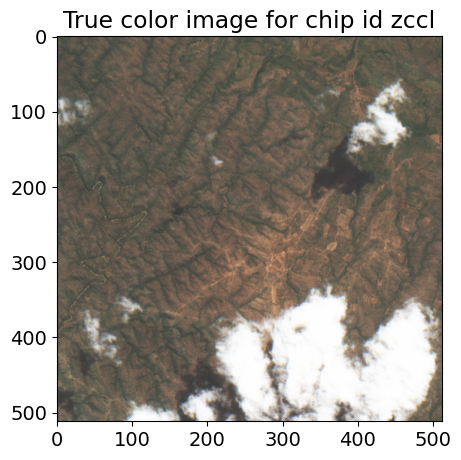

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")
plt.show()

In [62]:
35.73950387042965 == 35.73950387042965

True

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 8

In [63]:
# Chart - 8 visualization code
def display_random_chip(random_state):
    """Displays a true color image and the corresponding label for that chip"""
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = df.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = get_xarray(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

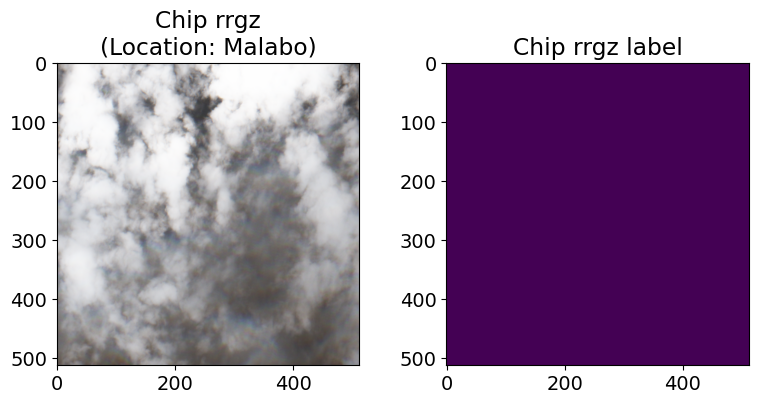

In [64]:
display_random_chip(np.random.randint(10000))

In [65]:
np.random.randint(10000)

5734

In [66]:
def display_random_chip_bands(chip_id='none', random_state=1):
    """Displays a true color image, B02 band, B03 band, B04 band, B08 band and the corresponding label for that chip"""
    fig, ax = plt.subplots(1, 6, figsize=(20, 10))
    if chip_id == 'none':
        chip_id = df.sample(random_state=random_state).iloc[0]
    else:
        chip_id = df.loc[df['chip_id'] == chip_id].iloc[0]
    true_color = true_color_img(chip_id.chip_id)
    ax[0].imshow(true_color)
    ax[0].set_title(f'{chip_id.chip_id}')

    for i, band in enumerate(BANDS, 1):
        datarray = get_xarray(f'/content/data/train_features/{chip_id.chip_id}/{band}.tif')
        ax[i].imshow(datarray)
        ax[i].set_title(band)
    datarray = get_xarray(f'/content/data/train_labels/{chip_id.chip_id}.tif')
    ax[5].imshow(datarray)
    ax[5].set_title(f'label, {round(float(datarray.mean().data), 2)}')

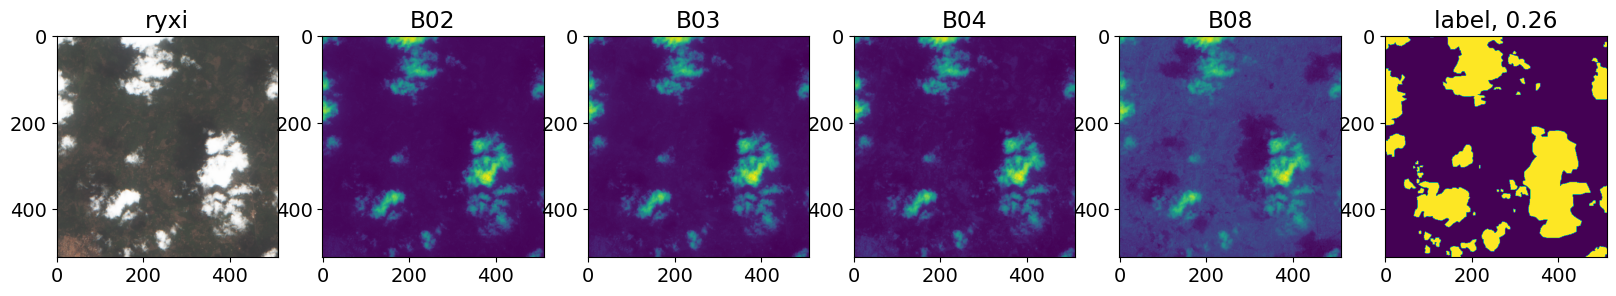

In [67]:
display_random_chip_bands(random_state = np.random.randint(100))

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 9

<ipython-input-68-7d697293b5f7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Text(0.5, 9.722222222222216, 'Feature/Property')

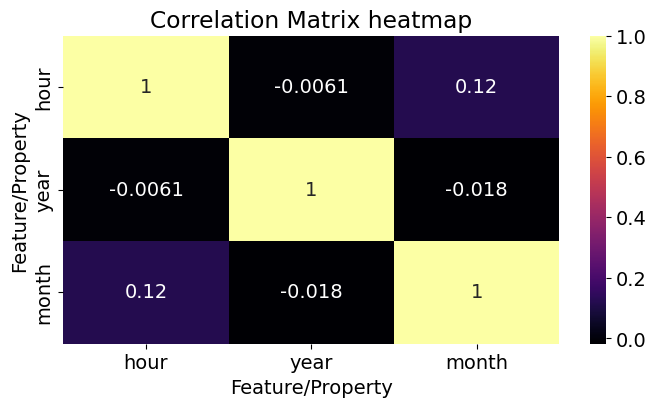

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 10

In [38]:
# Chart - 10 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 11

In [39]:
# Chart - 11 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 12

In [40]:
# Chart - 12 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 13

In [41]:
# Chart - 13 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 14 - Correlation Heatmap

In [42]:
# Correlation Heatmap visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 15 - Pair Plot

In [43]:
# Pair Plot visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

Answer Here.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [44]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [45]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [46]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [47]:
# Handling Missing Values & Missing Value Imputation

#### What all missing value imputation techniques have you used and why did you use those techniques?

Answer Here.

### 2. Handling Outliers

In [48]:
# Handling Outliers & Outlier treatments

##### What all outlier treatment techniques have you used and why did you use those techniques?

Answer Here.

### 3. Categorical Encoding

In [49]:
# Encode your categorical columns

#### What all categorical encoding techniques have you used & why did you use those techniques?

Answer Here.

### 4. Textual Data Preprocessing
(It's mandatory for textual dataset i.e., NLP, Sentiment Analysis, Text Clustering etc.)

#### 1. Expand Contraction

In [50]:
# Expand Contraction

#### 2. Lower Casing

In [51]:
# Lower Casing

#### 3. Removing Punctuations

In [52]:
# Remove Punctuations

#### 4. Removing URLs & Removing words and digits contain digits.

In [53]:
# Remove URLs & Remove words and digits contain digits

#### 5. Removing Stopwords & Removing White spaces

In [54]:
# Remove Stopwords

In [55]:
# Remove White spaces

#### 6. Rephrase Text

In [56]:
# Rephrase Text

#### 7. Tokenization

In [57]:
# Tokenization

#### 8. Text Normalization

In [58]:
# Normalizing Text (i.e., Stemming, Lemmatization etc.)

##### Which text normalization technique have you used and why?

Answer Here.

#### 9. Part of speech tagging

In [59]:
# POS Taging

#### 10. Text Vectorization

In [60]:
# Vectorizing Text

##### Which text vectorization technique have you used and why?

Answer Here.

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [61]:
# Manipulate Features to minimize feature correlation and create new features

#### 2. Feature Selection

In [62]:
# Select your features wisely to avoid overfitting

##### What all feature selection methods have you used  and why?

Answer Here.

##### Which all features you found important and why?

Answer Here.

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

In [63]:
# Transform Your data

### 6. Data Scaling

In [64]:
# Scaling your data

##### Which method have you used to scale you data and why?

### 7. Dimesionality Reduction

##### Do you think that dimensionality reduction is needed? Explain Why?

Answer Here.

In [65]:
# DImensionality Reduction (If needed)

##### Which dimensionality reduction technique have you used and why? (If dimensionality reduction done on dataset.)

Answer Here.

### 8. Data Splitting

In [66]:
# Split your data to train and test. Choose Splitting ratio wisely.

##### What data splitting ratio have you used and why?

Answer Here.

### 9. Handling Imbalanced Dataset

##### Do you think the dataset is imbalanced? Explain Why.

Answer Here.

In [67]:
# Handling Imbalanced Dataset (If needed)

##### What technique did you use to handle the imbalance dataset and why? (If needed to be balanced)

Answer Here.

## ***7. ML Model Implementation***

### ML Model - 1

In [68]:
# ML Model - 1 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [69]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [70]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### ML Model - 2

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [71]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [72]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

#### 3. Explain each evaluation metric's indication towards business and the business impact pf the ML model used.

Answer Here.

### ML Model - 3

In [73]:
# ML Model - 3 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [74]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [75]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

Answer Here.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

Answer Here.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

Answer Here.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [76]:
# Save the File

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [77]:
# Load the File and predict unseen data.

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

Write the conclusion here.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***